In [351]:

import mne


import pandas as pd
import mtrf
from mtrf.model import TRF
from mtrf.stats import crossval, nested_crossval
import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy


from scipy.io import loadmat, savemat
from scipy.stats import pearsonr, spearmanr
from scipy.stats.mstats import winsorize
from pingouin import rm_anova

from collections import Counter

import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

import pickle
import os

## Set up directories

In [392]:

train = 'motor'

mapchange_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected_since/'
pred_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/rTRF_predictions_{train}'
sv_dir ='/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv/'


## Visualize predictions

In [82]:
subject = '06'
period = 'post'

In [92]:
pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
pred_stim = pred_data['predicted_stim'][0]
pred_corr = pred_data['pearsonr']
sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0]
sv_firsts = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['firsts'][0]

print(pred_corr)

[[0.06608193]]


In [147]:
pred_stim_winsorized = winsorize(pred_stim, limits = [0.005, 0.005])

(30000.0, 40000.0)

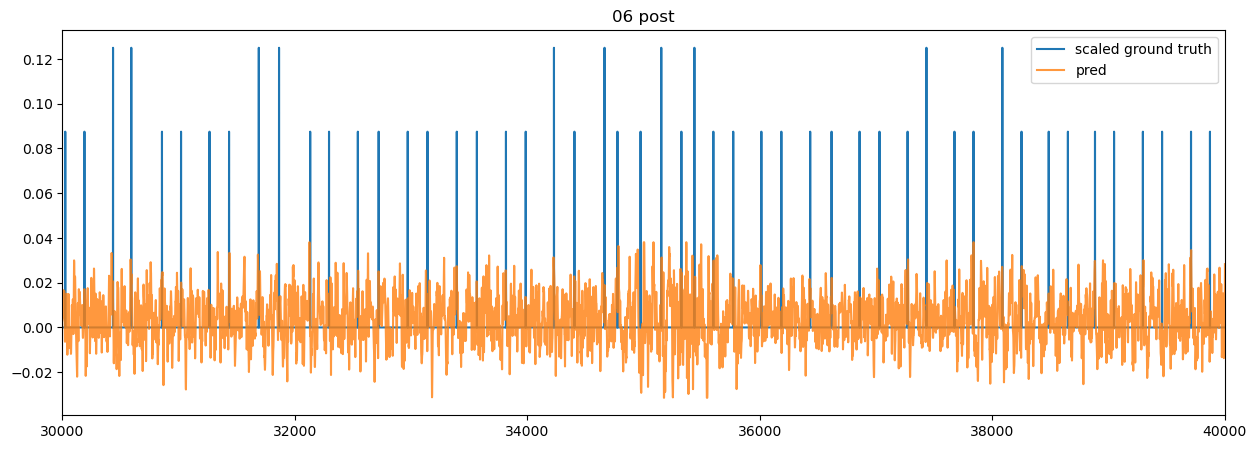

In [158]:
plt.figure(figsize = (15,5))
plt.plot(sv_firsts/8, label = 'scaled ground truth')
plt.plot(pred_stim_winsorized, alpha = 0.8, label = 'pred')
plt.title(f'{subject} {period}')
plt.legend()

plt.xlim(30000,40000)

In [157]:
pearsonr(pred_stim_winsorized, sv_onsets)

PearsonRResult(statistic=0.07098794209911019, pvalue=2.2748765585336373e-86)

In [34]:
#load predictions

# fo_df = pd.read_csv(os.path.join(mapchange_path, f'mapchange_keystrokes_pre_{subject}.csv'))
# others_times = fo_df[fo_df['type']=='other']['time']
# firsts_times = fo_df[fo_df['type']=='first']['time']

## Correlate with support vectors

In [42]:
import seaborn as sns

01
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19
20


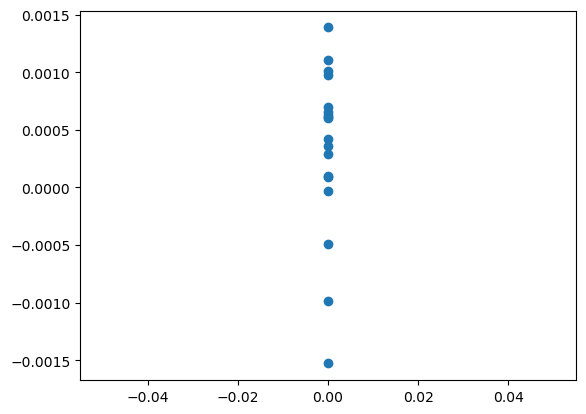

In [173]:
pearson_o = []
pearson_f = []
winsorize_preds  = True
invert = True

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()

#subjects_to_process =  ['06', '07', '08', '09', '10', '11', '12']
subjects_to_process =  good_error_subjects


for subject in subjects_to_process:
    print(subject)
    pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
    pred_stim = pred_data['predicted_stim'][0]

    if winsorize_preds: 
        pred_stim = winsorize(pred_stim, limits = [0.005, 0.005])

    #load support vectors
    sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0] 
    sv_firsts = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['firsts'][0] 

    if sv_firsts.shape[0]>pred_stim.shape[0]:
        sv_firsts = sv_firsts[:pred_stim.shape[0]]
        sv_onsets = sv_onsets[:pred_stim.shape[0]]
        
    if invert:
        sv_onsets = sv_onsets*-1
        sv_firsts = sv_firsts*-1

    
    #correlation with support vectors
    res_o = pearsonr(pred_stim, sv_onsets) 
    res_f = pearsonr(pred_stim, sv_firsts)

    pearson_o.append(res_o.statistic)
    pearson_f.append(res_f.statistic)

    #plt.plot([1,2], [res_o.statistic, res_f.statistic])

pearson_f = np.array(pearson_f)
pearson_o = np.array(pearson_o)
pearson_diff = pearson_f - pearson_o


In [299]:
# pearson_o = []
# pearson_f = []

corr_data = []
winsorize_preds  = True
invert = False
sv_to_test = ['firsts', 'firsts_sur', 'onsets_sur', 'fo_sur']
period = 'post' #post has good results

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
#subjects_to_process =  ['06', '07', '08', '09', '10', '11', '12']
subjects_to_process =  good_error_subjects


for subject in subjects_to_process:
    sub_data = {
        'subject':subject,
        'period':period,
        }
    
    pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
    pred_stim = pred_data['predicted_stim'][0]

    if winsorize_preds: 
        pred_stim = winsorize(pred_stim, limits = [0.005, 0.005])

    #load onset support vector
    sv_onsets = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))['onsets'][0] 
    if sv_onsets.shape[0]>pred_stim.shape[0]:
        sv_onsets = sv_onsets[:pred_stim.shape[0]]
    if invert:
        sv_onsets = sv_onsets*-1
    res_o = pearsonr(pred_stim, sv_onsets) 
    sub_data['onset_raw'] = res_o.statistic

    #loop through other support vectors
    for sv in sv_to_test:
        sv_tocompare = loadmat(os.path.join(sv_dir, f'sv_data_{period}_{subject}.mat'))[sv][0] 

        if sv_tocompare.shape[0]>pred_stim.shape[0]:
            sv_tocompare = sv_tocompare[:pred_stim.shape[0]]
            
            
        if invert:
            
            sv_tocompare = sv_tocompare*-1

        
        #correlation with support vectors
        
        res_f = pearsonr(pred_stim, sv_tocompare)
        diff = res_f.statistic - res_o.statistic

        sub_data[sv] = diff
        sub_data[sv+'_raw'] = res_f.statistic
        
    corr_data.append(sub_data)

corr_data = pd.DataFrame(corr_data)


In [273]:
corr_data_toplot = corr_data.melt(id_vars = ['subject', 'period'],
                                  value_vars = sv_to_test,
                                  value_name = 'diff',
                                  var_name='sv_type',
                                  
)

In [274]:
corr_data_toplot

,subject,period,sv_type,diff
0,01,pre,firsts,0.000961
1,04,pre,firsts,-0.001798
2,05,pre,firsts,-0.001707
3,06,pre,firsts,0.000708
4,07,pre,firsts,-0.000958
...,...,...,...,...
67,16,pre,fo_sur,0.042811
68,17,pre,fo_sur,0.040426
69,18,pre,fo_sur,0.039252
70,19,pre,fo_sur,0.051510


In [248]:
from statannotations.Annotator import Annotator
from itertools import combinations
from scipy.stats import ttest_rel, ttest_1samp

In [249]:

corr_data_toplot

,subject,period,sv_type,diff
0,01,post,firsts,0.000608
1,04,post,firsts,-0.000031
2,05,post,firsts,-0.000989
3,06,post,firsts,0.000358
4,07,post,firsts,0.000092
...,...,...,...,...
67,16,post,fo_sur,0.038019
68,17,post,fo_sur,0.034733
69,18,post,fo_sur,0.040055
70,19,post,fo_sur,0.068922


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

firsts vs. firsts_sur: Custom statistical test, P_val:4.546e-08
firsts_sur vs. onsets_sur: Custom statistical test, P_val:1.765e-08
onsets_sur vs. fo_sur: Custom statistical test, P_val:1.682e-08
firsts vs. onsets_sur: Custom statistical test, P_val:7.782e-07
firsts_sur vs. fo_sur: Custom statistical test, P_val:4.104e-08
firsts vs. fo_sur: Custom statistical test, P_val:4.232e-08
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

firsts vs. firsts: Custom statistical test, P_val:5.798e-01
firsts_sur vs. firsts_sur: Custom statistical test, P_val:7.629e-06
onsets_sur vs. onsets_sur: Custom statistical test, P_val:7.629e-06
fo_sur vs. fo_sur: Custom statistica

Text(0.5, 36.58159722222221, '')

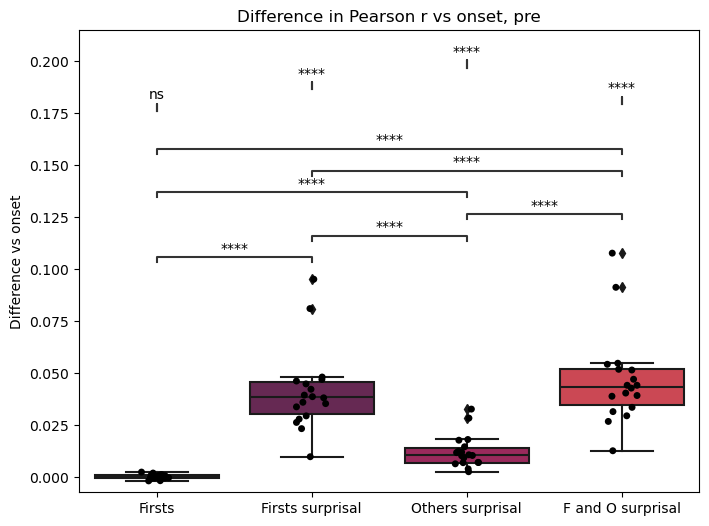

In [275]:
sns.set_palette('rocket')

plt.figure(figsize = (8,6))
ax = sns.boxplot(data = corr_data_toplot, x = 'sv_type', y = 'diff')
ax = sns.stripplot(data = corr_data_toplot, x = 'sv_type', y = 'diff', color = 'black')

#pairwise comparisons between categories
pairs = list(combinations(sv_to_test, 2))
p_values_dict = {pair:ttest_rel(corr_data[pair[0]],
                                  corr_data[pair[1]]).pvalue 
            for pair in pairs}

annotator = Annotator(ax, pairs, data=corr_data_toplot, x='sv_type', y='diff')

p_values = list(p_values_dict.values())
annotator.set_pvalues(p_values)
annotator.annotate()

#test all categories against 0
pairs = [(sv_type,sv_type) for sv_type in sv_to_test]

annotator_1samp = Annotator(ax, pairs, data=corr_data_toplot, x='sv_type', y='diff')

p_values_1samp = []
for sv_type in sv_to_test:
    group_data = corr_data[sv_type]
    t_stat, p_val = wilcoxon_1samp(group_data)
    p_values_1samp.append(p_val)
annotator_1samp.set_pvalues(p_values_1samp)

annotator_1samp.annotate(line_offset_to_group=0.4)

plt.title(f'Difference in Pearson r vs onset, {period}')
plt.ylabel('Difference vs onset')
plt.xticks([0,1,2,3], labels = ['Firsts', 'Firsts surprisal', 'Others surprisal', 'F and O surprisal' ])
plt.xlabel('')

In [ ]:


plt.scatter(np.zeros_like(pearson_diff), pearson_diff)
    #plt.plot([1,2], [pearson_o, pearson_f])
    

    


In [174]:
wilcoxon_1samp(pearson_diff)

WilcoxonResult(statistic=40.0, pvalue=0.04827880859375)

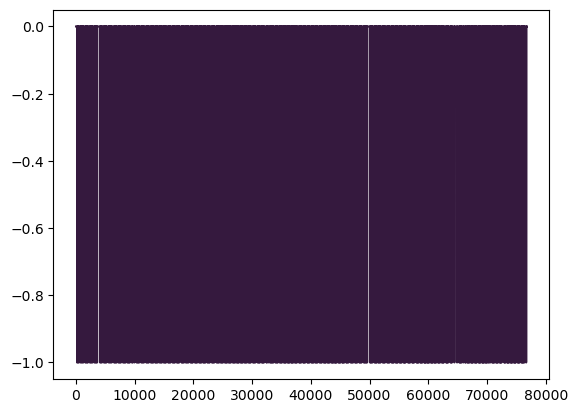

In [268]:
plt.plot(sv_onsets)

## Correlate with scores

In [242]:
subjects_to_process = ['06', '07', '08', '09', '10', '11', '12']

In [233]:
scores_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils/training_scores_rank.csv') 

In [238]:
pearsonrs = []
for subject in subjects_to_process:
    pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
   # pred_stim = pred_data['predicted_stim']
    pred_corr = pred_data['pearsonr']
    pearsonrs.append(pred_corr[0][0])



## Firsts vs others

In [320]:
# firsts_amp = []
# others_amp = []
# for subject in subjects_to_process:
#     pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
#     pred_stim = pred_data['predicted_stim'][0]

#     #find times for keystrokes
#     fo_df = pd.read_csv(f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected/mapchange_keystrokes_{period}_{subject}.csv')
#     others_times = fo_df[fo_df['type']=='other']['time']
#     firsts_times = fo_df[fo_df['type']=='first']['time']

#     #compare reconstructed amplitudes at keystrokes
#     amp_others = pred_stim[others_times].mean()
#     amp_firsts = pred_stim[firsts_times].mean()

#     others_amp.append(amp_others)
#     firsts_amp.append(amp_firsts)

In [452]:
periods = ['pre', 'post']
pred_amp_df = []
subjects_to_process = good_error_subjects

for subject in subjects_to_process:
    for period in periods:

        sub_data = {
            'subject': subject,
            'period': period
        }

        pred_data = loadmat(os.path.join(pred_dir, f'pred_err_{subject}_{period}.mat'))
        pred_stim = pred_data['predicted_stim'][0]

        #find times for keystrokes
        fo_df = pd.read_csv(os.path.join(mapchange_dir,f'mapchange_keystrokes_{period}_{subject}.csv'))
        others_times = fo_df[fo_df['type']=='other']['time']
        firsts_times = fo_df[fo_df['type']=='first']['time']

        #compare reconstructed amplitudes at keystrokes
        amp_others = pred_stim[others_times].mean()
        amp_firsts = pred_stim[firsts_times].mean()

        sub_data['others'] = amp_others
        sub_data['firsts'] = amp_firsts
    
        pred_amp_df.append(sub_data)    

pred_amp_df = pd.DataFrame(pred_amp_df)



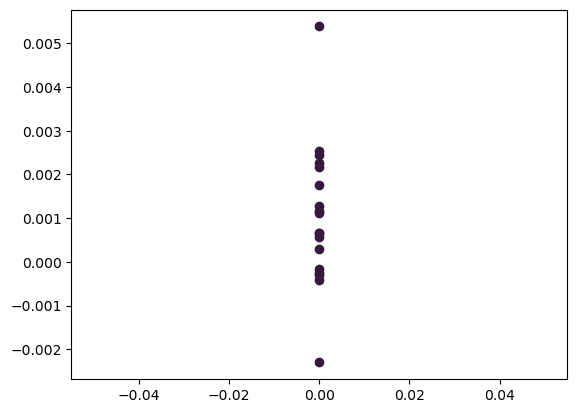

In [467]:
plt.scatter(np.zeros_like(pred_amp_df[pred_amp_df['period'] == 'post']['diff']), pred_amp_df[pred_amp_df['period'] == 'post']['diff'])

In [469]:
ttest_1samp(pred_amp_df[pred_amp_df['period']=='post']['diff'], popmean=0)

TtestResult(statistic=2.7305286800057607, pvalue=0.014236956765517287, df=17)

In [461]:
pred_amp_df['diff'] = pred_amp_df['firsts'] - pred_amp_df['others']

In [455]:
pred_amp_df_melt = pred_amp_df.melt(id_vars=['subject', 'period'], 
                 value_vars = ['others', 'firsts'], 
                 value_name = 'pred_amp',
                 var_name='type')

In [456]:
pred_amp_df_melt

,subject,period,type,pred_amp
0,01,pre,others,0.026160
1,01,post,others,0.020323
2,04,pre,others,0.009006
3,04,post,others,0.007783
4,05,pre,others,0.009731
...,...,...,...,...
67,18,post,firsts,0.005981
68,19,pre,firsts,-0.007877
69,19,post,firsts,-0.003028
70,20,pre,firsts,0.008084


In [457]:

anova_res = rm_anova(data = pred_amp_df_melt, dv = 'pred_amp', within = ['period', 'type'], subject = 'subject')


In [458]:
anova_res

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,period,0.000006,1,17,0.000006,0.360098,0.556367,0.556367,0.002312,1.0
1,type,0.000010,1,17,0.000010,6.531205,0.020472,0.020472,0.003788,1.0
2,period * type,0.000002,1,17,0.000002,0.699064,0.414696,0.414696,0.000590,1.0


In [459]:
pred_svg = loadmat('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/rTRF_predictions_listen/pred_err_09_pre.mat')['predicted_stim']
mapchange_df = pd.read_csv('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected_since/mapchange_keystrokes_pre_09.csv') 

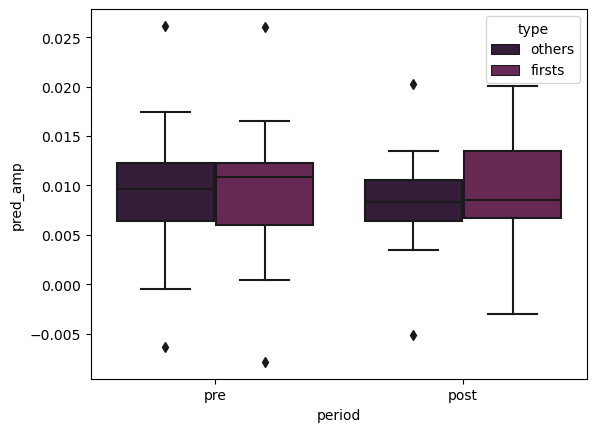

In [460]:
ax = sns.boxplot(data = pred_amp_df_melt, x = 'period', y = 'pred_amp', hue = 'type')

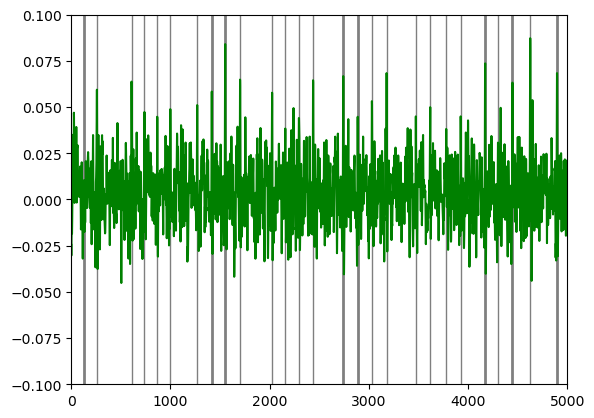

In [451]:
begin = 0
end = 5000
alpha = 0.5

plt.eventplot(other_times, lineoffsets = 0.1, linelength = 1, linewidths = 1, color = 'black', alpha = alpha)
plt.eventplot(first_times, lineoffsets = 0.1, linelength = 1, linewidths = 2, color = 'black', alpha = alpha)

plt.plot(pred_svg[0], color = 'green')
plt.xlim(begin, end)
plt.ylim(-0.1, 0.1)

plt.savefig('pred_listen.svg')